# In this notebook I will extrapolate the data of hits in 3D
this noteboko is inspired on the work of:
https://stackoverflow.com/questions/47235152/how-to-interpolate-3d-using-pythons-griddata

particle_id = 6183


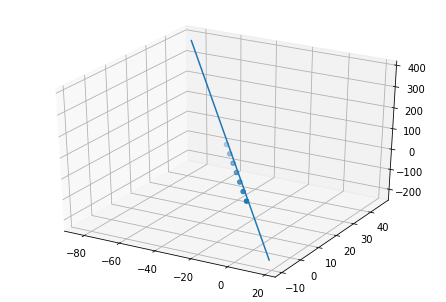

particle_id = 17086
particle_id = 1145


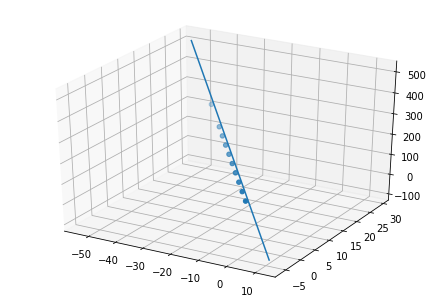

particle_id = 2257


/afs/cern.ch/work/p/ppayemam/miniconda/envs/ramp_velo_challenge/lib/python3.7/site-packages/scipy/optimize/minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 1400.
  warnings.warn(errors[info][0], RuntimeWarning)


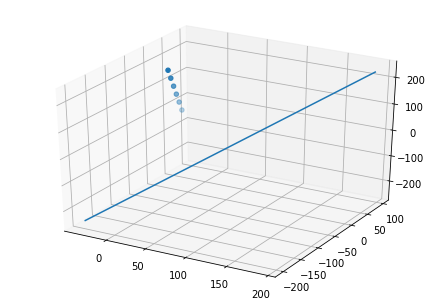

particle_id = 21127


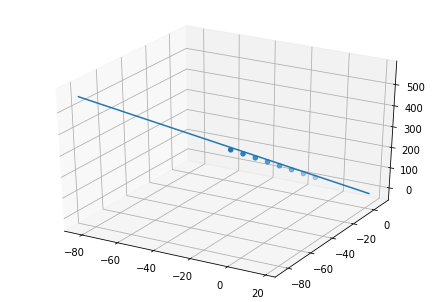

particle_id = 5516


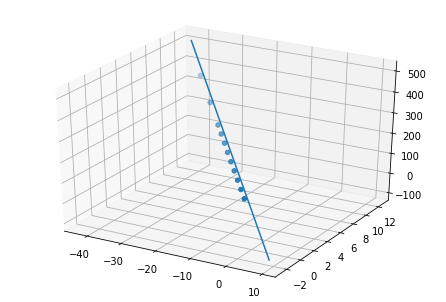

particle_id = 12398


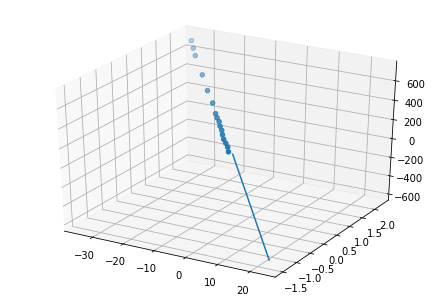

particle_id = 14442


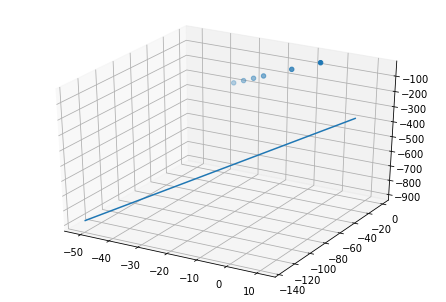

particle_id = 5681


TypeError: Improper input: N=6 must not exceed M=4

In [43]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
import numpy as np
from random import random
from scipy.optimize import leastsq, fmin
import pandas as pd
%matplotlib inline
  
def line_points( s, p, t ):
    return [ s * t[0] + p[0], s * t[1] + p[1], s * t[2] + p[2] ]

def weighted_dist( s, p, t, xVec, sigmaVec ):
    q = line_points( s, p, t )
    d  = ( q[0] - xVec[0] )**2 / sigmaVec[0]**2
    d += ( q[1] - xVec[1] )**2 / sigmaVec[1]**2
    d += ( q[2] - xVec[2] )**2 / sigmaVec[2]**2
    return np.sqrt( d )

def weighted_od( p, t, xVec, sigmaVec ):
    f = lambda s: weighted_dist( s, p, t, xVec, sigmaVec )
    sol = fmin( f, 0, disp=False )
    d = weighted_dist( sol[0], p, t, xVec, sigmaVec )
    return d

def residuals( params, data, sigmas ): ###data of type [ allx, ally, allz], sigma of type [allsx, allsy, allsz]
    px, py, pz, tx, ty, tz = params
    out = list()
    for x0, y0, z0, sx, sy, sz in zip( *( data + sigmas ) ):
        out += [weighted_od( [ py, py, pz ], [ tx, ty, tz ], [ x0, y0, z0 ], [ sx, sy, sz ] ) ]
    #print( sum(out))
    return out

df = pd.DataFrame()
df = pd.read_csv('data2/55microns50psInner55microns50psOuter_EventNumber.txt', sep=' ')

for particle_id in df.particle_id.values : 
    print(f"particle_id = {particle_id}") 
    if len(df.query(f"particle_id == {particle_id}") ) < 3 : 
           continue
    myP = np.array( [ 1 , 1, 3 ] )        
    myT = np.array( [ -1 ,-3, .8 ] )      
    myT /= np.linalg.norm( myT )          

    sList = np.linspace( -100, 500, 100 )
    lineList = [ line_points( s, myP, myT ) for s in sList] 
    """
    xData = [p[0] + .2 * ( 2 * random() - 1 ) for p in lineList ]
    yData = [p[1] + .4 * ( 2 * random() - 1 ) for p in lineList ]
    zData = [p[2] + .8 * ( 2 * random() - 1 ) for p in lineList ]
    """
    xData = df.query(f"particle_id == {particle_id}")['x'].values
    yData = df.query(f"particle_id == {particle_id}")['y'].values
    zData = df.query(f"particle_id == {particle_id}")['z'].values

    xyzData = [ xData, yData, zData ]
    sssData = [ len(xData) * [.2], len(xData) * [.4], len(xData) * [.8] ]

    residuals( [ 1, 1, 3, -1,-3,.8 ],  xyzData, sssData )
    myFit, err = leastsq(residuals, [ 1, 1, 2 , -1, -2, -1 ], args=( xyzData, sssData ) )
    # print(myFit)
    
    fitP = myFit[:3]
    fitT = myFit[3:]
    fitTN= np.linalg.norm( fitT )
    fitT = [ fitT[0] / fitTN, fitT[1] / fitTN, fitT[2] / fitTN ]
    fitLineList = [ line_points( s, fitP, fitT ) for s in sList ] 

    ax = m3d.Axes3D(plt.figure() )
    #ax.plot( *zip(*lineList) )
    ax.plot( *zip(*fitLineList) )
    ax.scatter3D( xData, yData, zData )
    plt.show()